In [53]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import lognorm
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler

In [54]:

cities = ['san_francisco', 'nyc_brooklyn', 'shenzhen_downtown_west', 'washington_dc']
city = cities[3]
with open(f"../data/scenario_{city}.json") as f:
    data = json.loads(f.read())

In [55]:
df = pd.DataFrame(data["demand"])

In [44]:
df

,time_stamp,origin,destination,demand,travel_time,price
0,1185,5,9,0.066667,18,33.3
1,1185,7,9,0.133333,7,13.3
2,1185,8,9,1.466667,10,13.5
3,1185,9,7,0.266667,10,14.6
4,1185,8,7,1.333333,10,12.3
...,...,...,...,...,...,...
5365,1259,6,5,0.200000,16,22.7
5366,1259,4,5,0.066667,6,11.6
5367,1259,4,7,0.133333,10,16.5
5368,1259,7,3,0.066667,11,18.0


In [5]:
(df["price"] / df["travel_time"]).min()

1.155

In [6]:
df["price"].max() / df["travel_time"].max()

1.261818181818182

In [7]:
json_start = 19*60
json_tstep = 3

In [8]:
df["converted_time_stamp"] = (df["time_stamp"]- 19 * 60) // 3

In [9]:
i = 5
j = 9
for step in range(20):
    loc_time_mask = (
        (df["origin"] == i)
        & (df["destination"] == j)
        & (
            (
                df["time_stamp"]
                - 19 * 60
            )
            // 3
            == step
        )
    )
    print(df.loc[loc_time_mask, "travel_time"].mean(), step)


17.0 0
17.0 1
17.0 2
17.0 3
17.0 4
10.0 5
10.0 6
10.0 7
10.0 8
10.0 9
nan 10
nan 11
nan 12
nan 13
nan 14
18.0 15
18.0 16
18.0 17
18.0 18
18.0 19


In [10]:
(df["travel_time"] - 19 * 60) // 3

0      -374
1      -378
2      -377
3      -377
4      -377
       ... 
5365   -375
5366   -378
5367   -377
5368   -377
5369   -378
Name: travel_time, Length: 5370, dtype: int64

In [11]:
df.loc[loc_time_mask, "travel_time"]

300    18
325    18
350    18
Name: travel_time, dtype: int64

In [12]:
reb_df = pd.DataFrame(data["rebTime"])
reb_df = reb_df[reb_df["time_stamp"]==19]

In [13]:
df_new = df.merge(reb_df, on=["origin", "destination"])

In [14]:
smf.ols(formula="price ~ reb_time", data=df_new).fit()

In [15]:
org, dest = 5, 9
test = df[(df["origin"] == org) & (df["destination"] == dest)] # 3.466

In [16]:
((test.travel_time * test.demand * 2/3) / (test.demand * 2)).round().unique()

array([6., 3., 7., 4., 5.])

In [17]:
df["travel_time"] /= 3

In [18]:
df["price"] = df["price"] * df["demand"] * 2

In [19]:
df[df["price"] == df["price"].max()]

,time_stamp,origin,destination,demand,travel_time,price,converted_time_stamp
3271,1155,7,5,0.6,18.333333,83.28,5
3301,1156,7,5,0.6,18.333333,83.28,5
3331,1157,7,5,0.6,18.333333,83.28,5
3361,1158,7,5,0.6,18.333333,83.28,6
3391,1159,7,5,0.6,18.333333,83.28,6
3421,1160,7,5,0.6,18.333333,83.28,6
3451,1161,7,5,0.6,18.333333,83.28,7
3481,1162,7,5,0.6,18.333333,83.28,7
3511,1163,7,5,0.6,18.333333,83.28,7
3541,1164,7,5,0.6,18.333333,83.28,8


# Simple summary stats

In [56]:
df_org_dest = df.groupby(["origin", "destination"]).agg({"price": ["count", "mean"], "demand": "mean", "travel_time":"mean"}).reset_index()

In [57]:
df_org_dest.head()

origin destination price               demand travel_time
                     count       mean      mean        mean
0      0           1   120  13.400000  0.066667   14.000000
1      0           2   180  15.266667  0.077778   20.666667
2      0           3   180  12.166667  0.138889   14.333333
3      0           4   180   9.333333  0.688889    9.666667
4      0           5   180  12.433333  0.838889   14.666667

In [58]:
df_org_dest.columns = df_org_dest.columns.droplevel(0)
df_org_dest.columns = ["Origin", "Destination", "count", "mean_price", "mean_demand", "mean_travel_time"]

In [59]:
df.describe()

time_stamp        origin   destination        demand   travel_time  \
count  24780.000000  24780.000000  24780.000000  24780.000000  24780.000000   
mean    1227.320823      5.992736      7.576271      0.121186     13.871671   
std       51.719791      4.017892      4.392148      0.182164      7.010372   
min     1140.000000      0.000000      0.000000      0.016667      3.000000   
25%     1183.000000      3.000000      4.000000      0.016667      9.000000   
50%     1226.000000      6.000000      7.000000      0.050000     12.000000   
75%     1271.000000      9.000000     11.000000      0.133333     17.000000   
max     1319.000000     16.000000     17.000000      0.966667     68.000000   

              price  
count  24780.000000  
mean      11.722518  
std        3.827296  
min        0.000000  
25%        9.000000  
50%       11.000000  
75%       13.600000  
max       24.900000

In [60]:
print(f"Origin nodes: {np.sort(df.origin.unique())}")
print(f"Destination nodes: {np.sort(df.destination.unique())}")

Origin nodes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 16]
Destination nodes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


# Grid analysis

In [61]:
pivot_df = df_org_dest.pivot(index='Origin', columns='Destination', values='count').T
pivot_df = pivot_df

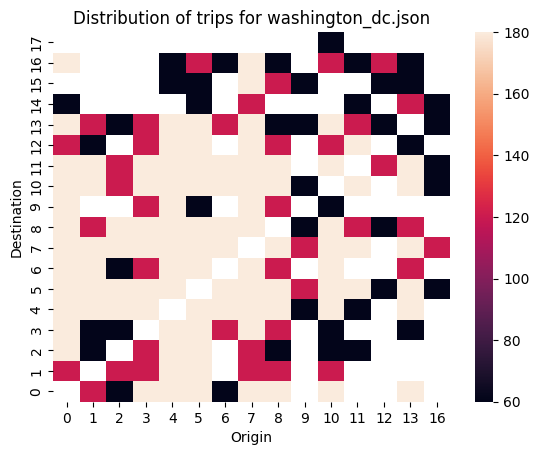

In [62]:
sns.heatmap(pivot_df.iloc[::-1], annot=False, fmt="d")
plt.title(f"Distribution of trips for {city}.json")
plt.xlabel(pivot_df.columns.name)
plt.ylabel(pivot_df.index.name)
plt.savefig(f"./figs/DistributionOfTrips_{city}")
plt.show()

In [63]:
# mean_demand_matrix = df.groupby("origin")["demand"].mean().values.reshape(1,pivot_df.shape[1])
# plt.figure(figsize=(10, 8))
# sns.heatmap(mean_demand_matrix.reshape(2,5), annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Mean Demand'}, annot_kws={"size": 12})
# plt.title('Heatmap of Mean Demand in Each Grid')
# plt.xlabel('Longitude Grid')
# plt.ylabel('Latitude Grid')
# plt.show()

# Travel time analysis

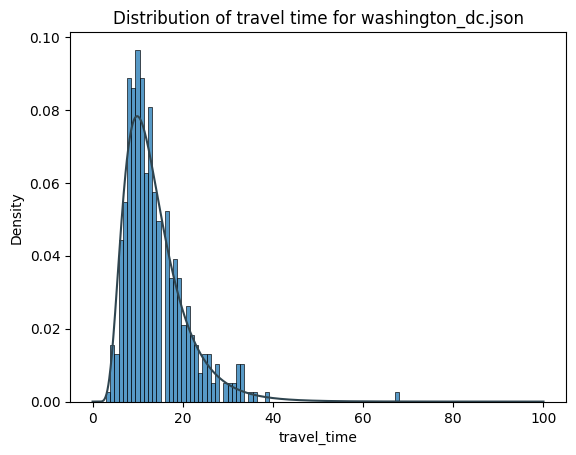

In [64]:
x = np.linspace(0, 100, 1000)
fitted_params = lognorm.fit(df["travel_time"])
sns.histplot(df["travel_time"], bins=70, stat="density")
plt.plot(x, lognorm(*fitted_params).pdf(x), color="#2F4550")
plt.title(f"Distribution of travel time for {city}.json")
plt.savefig(f"./figs/TravelTimeDist_{city}")
plt.show()

# Price analysis

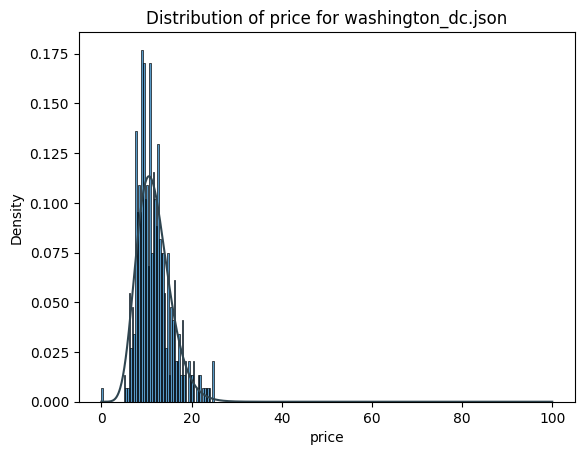

In [65]:
x = np.linspace(0, 100, 1000)
fitted_params = lognorm.fit(df["price"])
sns.histplot(df["price"], bins=70, stat="density")
plt.plot(x, lognorm(*fitted_params).pdf(x), color="#2F4550")
plt.title(f"Distribution of price for {city}.json")
plt.savefig(f"./figs/DistOfPrice_{city}")
plt.show()

In [48]:
pred_df = df.copy()

In [67]:
pred_df["poly_travel_time"] = pred_df["travel_time"]**2
pred_df["poly_demand"] = pred_df["demand"]**2
pred_df["log_price"] = np.log(pred_df["price"])

c:\Users\joach\AppData\Local\pypoetry\Cache\virtualenvs\multi-agent-reinforcement-learning-POZmGtHo-py3.10\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [68]:
sc = StandardScaler()

In [69]:
fitted_glm = glm_model.fit()

In [70]:
fitted_glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  price   No. Observations:                24780
Model:                            GLM   Df Residuals:                    24777
Model Family:                Gaussian   Df Model:                            2
Link Function:               Identity   Scale:                          3.2457
Method:                          IRLS   Log-Likelihood:                -49747.
Date:                Mon, 27 Nov 2023   Deviance:                       80419.
Time:                        15:46:24   Pearson chi2:                 8.04e+04
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9702
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       4.9518      0.027    186.285      0.000       4.900       5.004
travel_time     0.4816      0.002    294.940      0.000       0.478       0.485
demand          0.7492      0.063     11.923      0.000       0.626       0.872
===============================================================================
"""

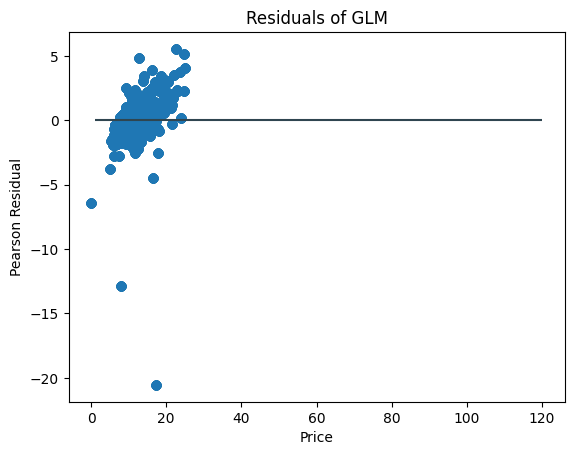

In [71]:
sns.kdeplot(df["price"])

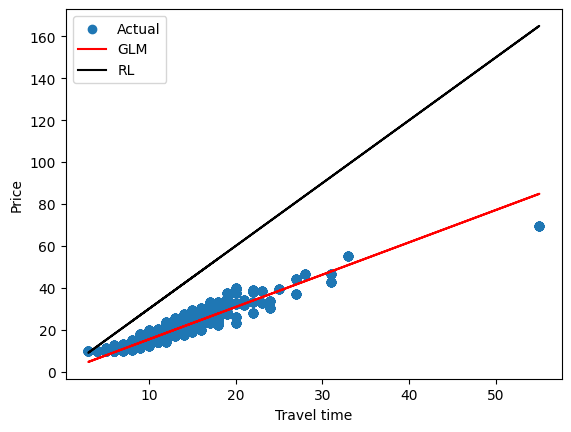

In [56]:
plt.scatter(df["travel_time"], df["price"], label="Actual")
plt.plot(df["travel_time"], fitted_glm.predict(), color="red", label="GLM")
plt.plot(df["travel_time"], df["travel_time"]*3, color="black", label="RL")
#plt.plot(df["travel_time"], df["travel_time"]*2, color="magenta", label="RL2")
plt.xlabel("Travel time")
plt.ylabel("Price")
plt.legend()
plt.savefig("reg_with_rl.png")
plt.show()

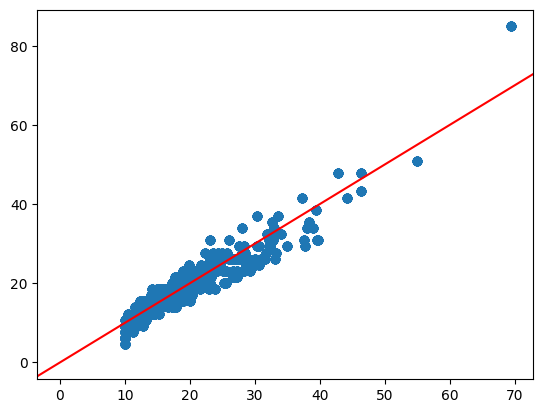

In [78]:
plt.scatter(pred_df["price"], fitted_glm.predict())
plt.axline((0,0), slope=1, color="red")
plt.show()

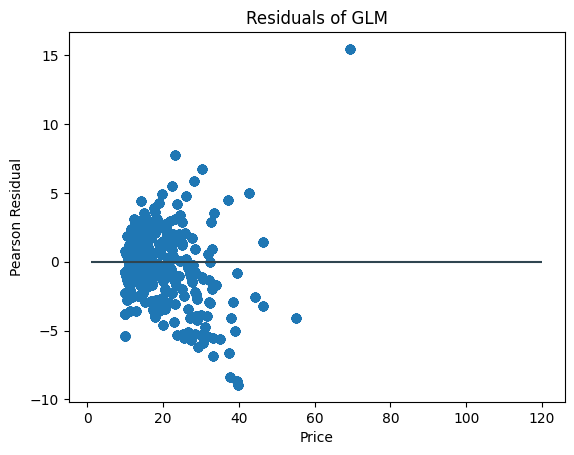

In [79]:
plt.scatter(pred_df["price"], fitted_glm.predict() - pred_df["price"])
plt.hlines(y=0, xmin=1, xmax=120, color="#2F4550")
plt.xlabel("Price")
plt.ylabel("Pearson Residual")
plt.title("Residuals of GLM")
plt.show()

# Predicting demand

In [174]:
def model_2(vars, travel_time):
    alpha, beta = vars
    demand_hat = np.exp(alpha + beta * travel_time)
    return demand_hat

In [175]:
def mse_model2(vars, price, travel_time):
    price_hat = model_2(vars, travel_time)
    return np.mean((price-price_hat)**2)

In [180]:
x0 = (0,0)
res = minimize(mse_model2, x0, args=(df.price, df.travel_time), tol=1e-3, method="Powell")

In [181]:
res

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 20.92744780137508
       x: [ 2.447e+00  3.932e-02]
     nit: 4
   direc: [[ 1.000e+00  0.000e+00]
           [-2.373e-01  1.697e-02]]
    nfev: 98

In [182]:
res.x

array([2.44746718, 0.03932451])

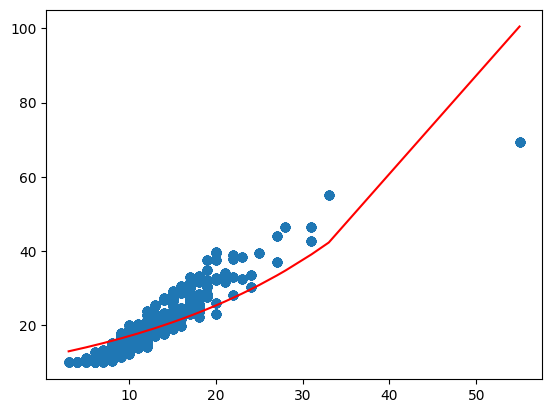

In [183]:
plt.plot(df.travel_time.sort_values(ascending=False).values, model_2(res.x, df.travel_time.sort_values(ascending=False).values), color="red")
plt.scatter(df.travel_time.sort_values(ascending=False).values,df.sort_values("travel_time", ascending=False).price.values)
plt.show()

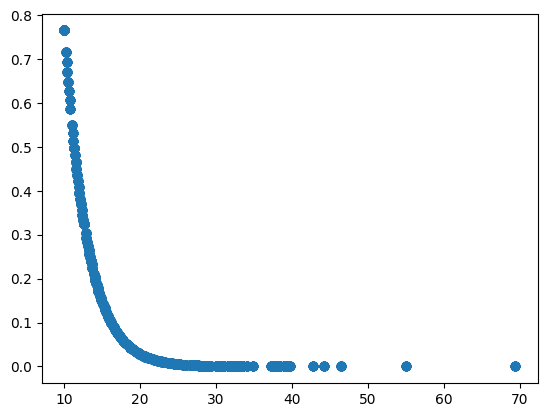

In [108]:
plt.scatter(df["price"], np.exp(res.x[0] + res.x[1] * df["price"]))

In [ ]:
plt.plot(df.price.sort_values(ascending=False).values, model_2(res.x, df.demand.sort_values(ascending=False).values), color="red")
plt.scatter(df.price.sort_values(ascending=False).values,df.sort_values("price", ascending=False).demand.values)